# Object Detection on DOTA
## 1. Import module and package

In [1]:
from __future__ import print_function
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pickle
import argparse
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import numpy as np
from torch.autograd import Variable
from data import VOCroot, COCOroot, VOC_300, VOC_512, COCO_300, COCO_512, COCO_mobile_300, AnnotationTransform, \
    COCODetection, VOCDetection, detection_collate, BaseTransform, preproc,DOTA_500, DOTAroot, DOTADetection,DOTA_CLASSES
import cv2
import torch.utils.data as data
from layers.functions import Detect,PriorBox
from utils.nms_wrapper import nms
from utils.timer import Timer

# 可视化依赖库
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, Circle
import math

print(torch.__version__)

1.0.1.post2


## 2. 相关参数设置
### 1. build net

In [2]:
trained_model = '/home/b622/project/PytorchSSD-dota/weights/DOTAweights/RFB_vgg_DOTA_300/2019-05-21-00:19/RFB_vgg_DOTA_epoches_300.pth'
img_dim = 300
num_classes = len(DOTA_CLASSES)
num_images = 1
rgb_means = (100.95,100.55,95.21) # RFB for voc
cuda = True
top_k = 200
cfg = VOC_300
detector = Detect(num_classes,0,cfg)
priorbox = PriorBox(cfg) # 锚框
priors = priorbox.forward().cuda() # PyTorch版本不对，还要用Variable
max_per_image=300
thresh=0.005
rgb_std = (1, 1, 1)
val_sets = 'subset_planes_500_gap200_val_GSC' # A subset of DOTA for testing
val_list = 'plane_val' # dataset type

## Build RFB300 in Test Phase

In [3]:
# init net 
from models.RFB_Net_vgg import build_net
net = build_net(img_dim, num_classes,phase='test')
net.load_weights(trained_model)
net.eval()

Loading weights into state dict...
Finished!


RFBNet(
  (base): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (17): Conv2d(2

In [4]:
testset = DOTADetection(DOTAroot, val_sets, None, 
                        AnnotationTransform(),
                        dataset_name = val_list)

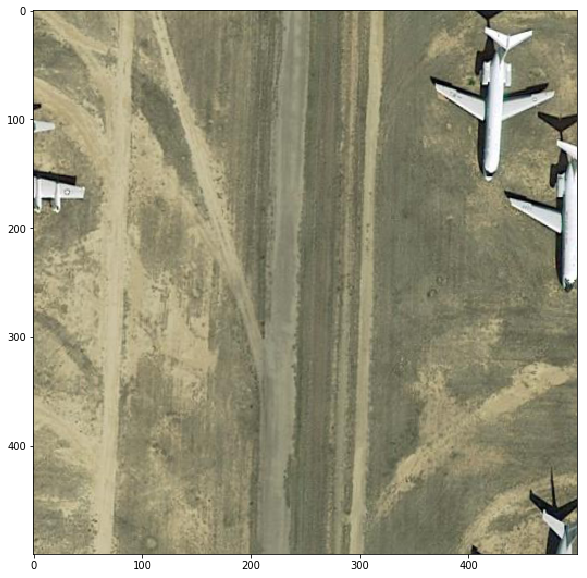

In [5]:
img_id = 100
image = testset.pull_image(img_id)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


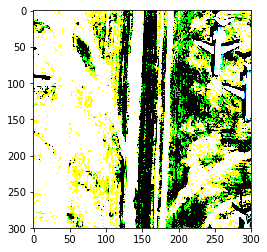

In [6]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

In [7]:
#
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
out = net(xx)

#
boxes, scores = detector.forward(out,priors)
boxes = boxes[0]
scores = scores[0]
scale = torch.Tensor([image.shape[1], image.shape[0],image.shape[1], image.shape[0]])
if torch.cuda.is_available():
    scale = scale.cuda()
boxes *= scale
# 放入CPU，便于后续NMS
boxes = boxes.cpu().numpy()
scores = scores.cpu().numpy()

#
all_boxes = [[[] for _ in range(num_images)]for _ in range(num_classes)]
i=0
for j in range(1, num_classes):
    inds = np.where(scores[:, j] > thresh)[0]
    if len(inds) == 0:
        all_boxes[j][i] = np.empty([0, 5], dtype=np.float32)
        continue
    c_bboxes = boxes[inds]
    c_scores = scores[inds, j]
    c_dets = np.hstack((c_bboxes, c_scores[:, np.newaxis])).astype(np.float32, copy=False)
    
    keep = nms(c_dets, 0.45, force_cpu=True) # 非极大抑制
    c_dets = c_dets[keep, :]
    all_boxes[j][i] = c_dets
if max_per_image > 0:
    image_scores = np.hstack([all_boxes[j][i][:, -1] for j in range(1,num_classes)]) #取出当前图像上非极大抑制后留下的所有框的置信度信息
    if len(image_scores) > max_per_image:
        image_thresh = np.sort(image_scores)[-max_per_image] #挑选出置信度阈值
        for j in range(1, num_classes):
            keep = np.where(all_boxes[j][i][:, -1] >= image_thresh)[0] #挑选出置信度排名前max_per_image的预测框
            all_boxes[j][i] = all_boxes[j][i][keep, :]
# all_boxes 所有框
# all_boxes[num_class][num_image][num_box]
# box = [4个位置信息，1个置信度]
print((all_boxes[1][0][0]))

[363.50784     8.7030525 481.43637   160.18181     0.9999875]


/home/b622/project/PytorchSSD-dota/models/RFB_Net_vgg.py:216: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.softmax(conf.view(-1, self.num_classes)),  # conf preds


image size is: (500, 500, 3)
(6, 5)
the number of boxes:  6 label: plane
[363.50784     8.7030525 481.43637   160.18181     0.9999875]
[4.2810074e+02 1.1571531e+02 5.0105930e+02 2.6467096e+02 4.0050030e-01]


/home/b622/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


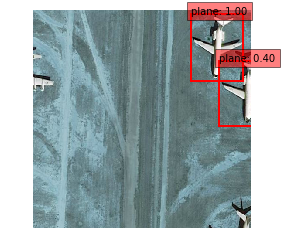

In [8]:
# 可视化
print('image size is:',image.shape)
plt.imshow(image)
plt.axis('off')
ax = plt.gca()
ax.set_autoscale_on(False)
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 15.0) # 调整显示图像大小
polygons = []
color = []
circles = []
currentAxis = plt.gca()
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for k in range(1, num_classes):
    dets = all_boxes[k][i] # 一个种类的所有水平框
    print(dets.shape)
    if dets == []:
        continue
    print('the number of boxes: ', dets.shape[0], 'label:', DOTA_CLASSES[k])
    for s in range(dets.shape[0]): # 遍历所有框
        if dets[s][-1] >= 0.06:
            print (dets[s])
            c = (np.random.random((1, 3)) * 0.6 + 0.4).tolist()[0] # 随机选颜色
            #color.append(c)
            """
            xc,yc,w,h = dets[s][:4]
            xmin = xc - w/2
            xmax = xc + w/2
            ymin = yc - h/2
            ymax = yc + h/2
            """
            xmin,ymin,xmax,ymax = dets[s][:4]
            if xmin < 0: xmin =0
            if ymin < 0: ymin =0
            if xmax > image.shape[0]: xmax = image.shape[0]
            if ymax > image.shape[0]: ymax = image.shape[1]
            #poly = [(xmin,ymax),(xmin,ymin),(xmax,ymin),(xmax,ymax)]
            #polygons.append(Polygon(poly)) #append应该是允许多次画框
            # 标签
            #text = DOTA_CLASSES[k]+ ':' + '{:.3f}'.format(dets[s, -1])
            #cv2.rectangle(img, (int(dets[s, 0] + 1),int(dets[s, 1] + 1)), (int(dets[s, 2] + 1),int(dets[s, 3] + 1)), colors[k], 2)
            #cv2.putText(img, text, (int(dets[s, 0] + 1),int(dets[s, 1] + 1)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[k], 1)
            display_txt = '%s: %.2f'%(DOTA_CLASSES[k], dets[s, -1])
            pt = dets[s][:4]
            coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
            color = colors[i]
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
            currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        
#p = PatchCollection(polygons, facecolors=color, linewidths=0, alpha=0.4)
#ax.add_collection(p)
#p = PatchCollection(polygons, facecolors='none', edgecolors=color, linewidths=2)
#ax.add_collection(p)

image size is: (500, 500, 3)
(29, 5)
the number of boxes:  29 label: plane
[405.826     339.92267   440.2981    378.678       0.5918704]
[4.0445337e+02 2.9942133e+02 4.3534787e+02 3.3249915e+02 1.5085883e-01]
[4.0595169e+02 3.2405545e+02 4.3652573e+02 3.6137543e+02 7.5426951e-02]


/home/b622/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  app.launch_new_instance()


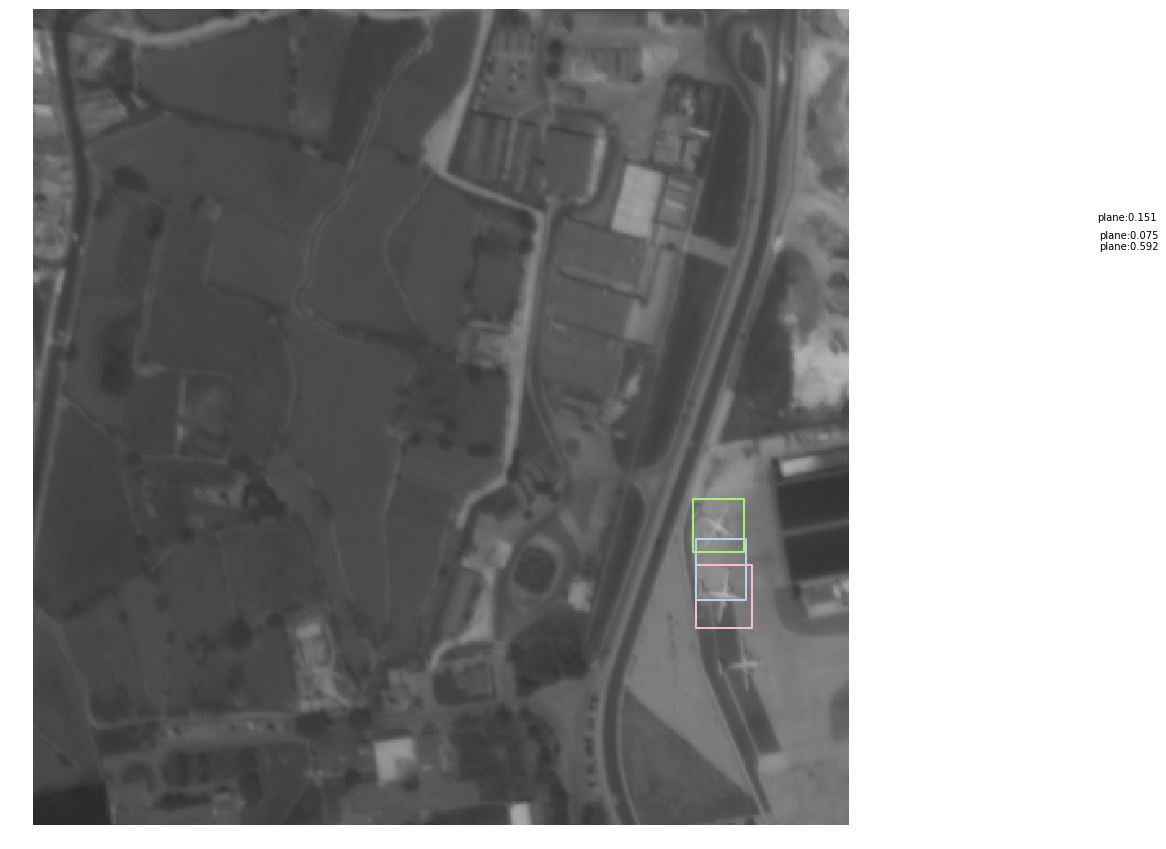

In [70]:
# 可视化
print('image size is:',image.shape)
plt.imshow(image)
plt.axis('off')
ax = plt.gca()
ax.set_autoscale_on(False)
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 15.0) # 调整显示图像大小
polygons = []
color = []
circles = []
colors = [(0,0,0),(128,0,0),(0,128,0),(128,128,0),(0,0,128),(128,0,128),(0,128,128),(128,128,128),(64,0,0),(192,0,0),(64,128,0),(192,128,0),(64,0,128),(192,0,128),(64,128,128),(192,128,128),(0,64,0),(128,64,0),(0,192,0),(128,192,0),(0,64,128)]
for k in range(1, num_classes):
    dets = all_boxes[k][i] # 一个种类的所有水平框
    print(dets.shape)
    if dets == []:
        continue
    print('the number of boxes: ', dets.shape[0], 'label:', DOTA_CLASSES[k])
    for s in range(dets.shape[0]): # 遍历所有框
        if dets[s][-1] >= 0.06:
            print (dets[s])
            c = (np.random.random((1, 3)) * 0.6 + 0.4).tolist()[0] # 随机选颜色
            color.append(c)
            """
            xc,yc,w,h = dets[s][:4]
            xmin = xc - w/2
            xmax = xc + w/2
            ymin = yc - h/2
            ymax = yc + h/2
            """
            xmin,ymin,xmax,ymax = dets[s][:4]
            if xmin < 0: xmin =0
            if ymin < 0: ymin =0
            if xmax > image.shape[0]: xmax = image.shape[0]
            if ymax > image.shape[0]: ymax = image.shape[1]
            poly = [(xmin,ymax),(xmin,ymin),(xmax,ymin),(xmax,ymax)]
            polygons.append(Polygon(poly)) #append应该是允许多次画框
            # 标签
            text = DOTA_CLASSES[k]+ ':' + '{:.3f}'.format(dets[s, -1])
            #cv2.rectangle(img, (int(dets[s, 0] + 1),int(dets[s, 1] + 1)), (int(dets[s, 2] + 1),int(dets[s, 3] + 1)), colors[k], 2)
            #cv2.putText(img, text, (int(dets[s, 0] + 1),int(dets[s, 1] + 1)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[k], 1)
            plt.annotate(text, xy=(int(xmin),int(ymax)),xytext=(int(xmin),int(ymax)), textcoords='offset points')
#p = PatchCollection(polygons, facecolors=color, linewidths=0, alpha=0.4)
#ax.add_collection(p)
p = PatchCollection(polygons, facecolors='none', edgecolors=color, linewidths=2)
ax.add_collection(p)